In [4]:
!pip install spacy-langdetect
!pip install language-detector
!pip install symspellpy
!pip install sentence-transformers
!pip install --upgrade gensim
!pip install pyLDAvis3
!pip install stop-words
!python -m pip install -U pyLDAvis
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

     |████████████████████████████████| 1.0MB 5.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993461 sha256=535991cd5cb0d1ae9e12278f24fb20fa08d2d18036ec13a9e19e8a7ee274aba5
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
  Created wheel for language-detector: filename=language_detector-5.0.2-cp36-none-any.whl size=7055 sha256=97c784a99ea2d2bd5821766312a0d405478eae0db018a5eb09bcd01f2678e8e6
  Stored in directory: /root/.cache/pip/wheels/7d/37/fa/2098a4aa6c0d94d6ddff0d3a79669e12bc4f7baca8a760b3db
Successfully built language-detector
     |████████████████████████████████| 2.6MB 4.4MB/s 
     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 12.9MB/s 
     |████████████████████████████████| 3.0MB 52.3MB/s 
     |████████████████████████████████| 1.1MB 51.3MB/s 
     |████████████████████████████████| 890kB 56.9MB/s 

True

In [5]:
#importing all dependencies.
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
from nltk.corpus import wordnet
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Topic Modeling with BERT, LDA, and Clustering
#### Latent Dirichlet Allocation (LDA) probabilistic topic assignment and pre-trained sentence embeddings from BERT/RoBERTa

## Model Deep Dive

The author used: 

* LDA for probabilistic topic assignment vector.
* Bert for sentence embedding vector.

1. Concatenated both LDA and Bert vectors with a weight hyperparameter to balance the relative importance of information from each source.
2. Used autoencoder to learn a lower dimensional latent space representation of the concatenated vector.

* The assumption is that the concatendate vector shoul have a manifold shaep in the high dimensional space. 
* USed clustering on the latent space representations to get topics. 



![Contextual Topic Identification model design](https://miro.medium.com/max/1410/1*OKCYnB-JbGq1NDwNSKd5Zw.png)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
complain_data = pd.read_excel(r'/content/drive/My Drive/CFPB LDA/CFPB_text_vs_cnsd_text_20201013_08_05_41.xlsx')
data = complain_data['Modified_text']

In [8]:
print(complain_data.info())
print(data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     11780 non-null  int64 
 1   Complaint_ID   11780 non-null  int64 
 2   Complain_text  11780 non-null  object
 3   Modified_text  11779 non-null  object
dtypes: int64(2), object(2)
memory usage: 368.2+ KB
None
0        qualify the dream program payment payment unti...
1        apply modification tell by my previous lender ...
2        my mortgage interest rate and payment with req...
3        apply mortgage loan with at the end receive pr...
4        have home equity loan and convert the home equ...
                               ...                        
11775    start modification with my mortgage company th...
11776    my problem with my lender so compile refinance...
11777    foreclose home base reverse mortgage and the b...
11778    at we think refinance our home but re

## Upload Data

**Data pipeline (from development to deployment**)

![Data pipeline (from development to deployment)](https://miro.medium.com/max/1348/1*Cdp4y1tfMxqoj96o6lUdFg.png)


Source:Shoa 

In [9]:
#https://www.kaggle.com/jieyang0311/covid-19-topic-modeling-lda
#load library
import os
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import datetime
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nltk

## Utils

In [10]:
from collections import Counter
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import os


def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:10])), word_counts))

    return topics

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if model.method == 'LDA':
        cm = CoherenceModel(model=model.ldamodel, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    else:
        topics = get_topic_words(token_lists, model.cluster_model.labels_)
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    return cm.get_coherence()

def get_silhouette(model):
    """
    Get silhouette score from model
    :param model: Topic_Model object
    :return: silhouette score
    """
    if model.method == 'LDA':
        return
    lbs = model.cluster_model.labels_
    vec = model.vec[model.method]
    return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)


def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    dr = '/kaggle/working/contextual_topic_identification/docs/images/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/kaggle/working/2D_vis')

def get_wordcloud(model, token_lists, topic):
    """
    Get word cloud of each topic from fitted model
    :param model: Topic_Model object
    :param sentences: preprocessed sentences from docs
    """
    if model.method == 'LDA':
        return
    print('Getting wordcloud for topic {} ...'.format(topic))
    lbs = model.cluster_model.labels_
    tokens = ' '.join([' '.join(_) for _ in np.array(token_lists)[lbs == topic]])

    wordcloud = WordCloud(width=800, height=560,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    dr = '/kaggle/working/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/kaggle/working' + '/Topic' + str(topic) + '_wordcloud')
    print('Getting wordcloud for topic {}. Done!'.format(topic))

## Preprocessing 

In [11]:
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
from language_detector import detect_language

import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


###################################
#### sentence level preprocess ####
###################################

# lowercase + base filter
# some basic normalization
def f_base(s):
    '''"""
    :param s: string to be processed
    :return: processed string: see comments in the source code for more info
    """
    # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    # normalization 2: lower case
    s = s.lower()
    # normalization 3: "&gt", "&lt"
    s = re.sub(r'&gt|&lt', ' ', s)
    # normalization 4: letter repetition (if more than 2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # normalization 5: non-word repetition (if more than 1)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # normalization 6: string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # normalization 7: stuff in parenthesis, assumed to be less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # normalization 8: xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # normalization 9: [.?!] --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    # normalization 10: ' ing ', noise text
    s = re.sub(r' ing ', ' ', s)
    # normalization 11: noise text
    s = re.sub(r'product received for free[.| ]', ' ', s)
    # normalization 12: phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)'''

    #return s.strip()
    return s


# language detection
def f_lan(s):
    """
    :param s: string to be processed
    :return: boolean (s is English)
    """

    # some reviews are actually english but biased toward french
    return 1


###############################
#### word level preprocess ####
###############################

# filtering out punctuations and numbers
def f_punct(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with punct and number filter out
    """
    return [word for word in w_list if word.isalpha()]


# selecting nouns
def f_noun(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']


# typo correction
def f_typo(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
            # do word segmentation, deprecated for inefficiency
            # w_seg = sym_spell.word_segmentation(phrase=word)
            # w_list_fixed.extend(w_seg.corrected_string.split())
    return w_list_fixed


# stemming if doing word-wise
p_stemmer = PorterStemmer()


def f_stem(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with stemming
    """
    return [p_stemmer.stem(word) for word in w_list]


# filtering out stop words
# create English stop words list

stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    #|set(get_stop_words('cy'))
    |set(get_stop_words('pt'))
    #|set(get_stop_words('tl'))
    |set(get_stop_words('pl'))
    #|set(get_stop_words('et'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    #|set(get_stop_words('so'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    #|set(get_stop_words('cs'))
    |set(get_stop_words('nl'))
    #|set(get_stop_words('sl'))
    #|set(get_stop_words('no'))
    #|set(get_stop_words('zh-cn'))
))





def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in stop_words]


def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    s = f_base(rw)
    if not f_lan(s):
        return None
    return s


def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    w_list = f_noun(w_list)
    w_list = f_typo(w_list)
    w_list = f_stem(w_list)
    w_list = f_stopw(w_list)

    return w_list

## Autoencoder

In [12]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

## Model

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim
import numpy as np
#from Autoencoder import *
#from preprocess import *
from datetime import datetime


def preprocess(docs, samp_size=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected
    #     samp = list(range(100))
    samp = np.random.choice(n_docs, samp_size)
    for i, idx in enumerate(samp):
        sentence = preprocess_sent(docs[idx])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists, idx_in


# define model object
class Topic_Model:
    def __init__(self, k=11, method='TFIDF'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT', 'LDA_BERT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vecotr representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'TFIDF':
            print('Getting vector representations for TF-IDF ...')
            tfidf = TfidfVectorizer()
            vec = tfidf.fit_transform(sentences)
            print('Getting vector representations for TF-IDF. Done!')
            return vec

        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Getting vector representations for BERT. Done!')
            return vec

             
        elif method == 'LDA_BERT':
        #else:
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec

    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)
                print('Fitting LDA Done!')
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method == "LDA":
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],
                                    corpus)))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs

## Training

In [14]:
#from model import *
#from utils import *

import pandas as pd
import pickle
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=Warning)

import argparse

#def model(): #:if __name__ == '__main__':

def main():
    
    
    #method = "TFIDF"
    #method = "LDA"
    method = "BERT"    
    #method = "LDA_BERT"
    samp_size = 10000
    ntopic = 11
    
    #parser = argparse.ArgumentParser(description='contextual_topic_identification tm_test:1.0')

    #parser.add_argument('--fpath', default='/kaggle/working/train.csv')
    #parser.add_argument('--ntopic', default=10,)
    #parser.add_argument('--method', default='TFIDF')
    #parser.add_argument('--samp_size', default=20500)
    
    #args = parser.parse_args()

    complain_data = pd.read_excel(r'/content/drive/My Drive/CFPB LDA/CFPB_text_vs_cnsd_text_20201013_08_05_41.xlsx')
    data = complain_data['Modified_text']
    sentences, token_lists, idx_in = preprocess(data, samp_size=samp_size)
    # Define the topic model object
    #tm = Topic_Model(k = 10), method = TFIDF)
    tm = Topic_Model(k = ntopic, method = method)
    # Fit the topic model by chosen method
    tm.fit(sentences, token_lists)

    print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
    print('Silhouette Score:', get_silhouette(tm))
    # visualize and save img
    visualize(tm)
    for i in range(tm.k):
        get_wordcloud(tm, token_lists, i)
        


Preprocessing raw texts ...
Preprocessing raw texts. Done!
Clustering embeddings ...
Getting vector representations for BERT ...


100%|██████████| 405M/405M [00:24<00:00, 16.4MB/s]



Getting vector representations for BERT. Done!
Clustering embeddings. Done!
Coherence: 0.4066564380788979
Silhouette Score: 0.03279066
Calculating UMAP projection ...
Calculating UMAP projection. Done!
Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!
Getting wordcloud for topic 4 ...
Getting wordcloud for topic 4. Done!
Getting wordcloud for topic 5 ...
Getting wordcloud for topic 5. Done!
Getting wordcloud for topic 6 ...
Getting wordcloud for topic 6. Done!
Getting wordcloud for topic 7 ...
Getting wordcloud for topic 7. Done!
Getting wordcloud for topic 8 ...
Getting wordcloud for topic 8. Done!
Getting wordcloud for topic 9 ...
Getting wordcloud for topic 9. Done!
Getting wordcloud for topic 10 ...
Getting wordcloud for topic 10. Done!


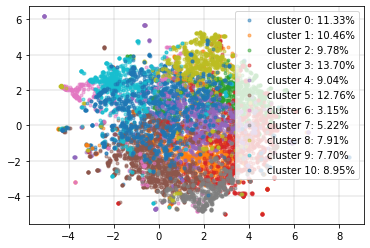

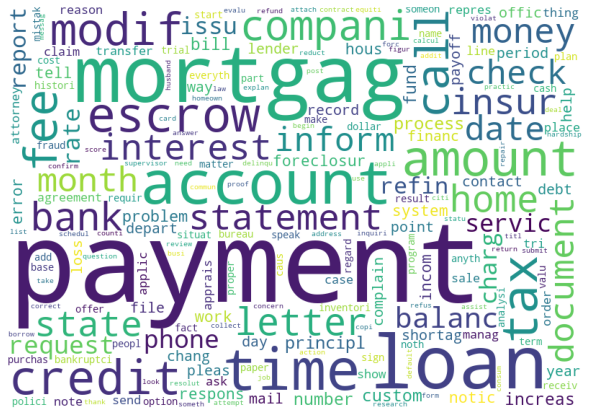

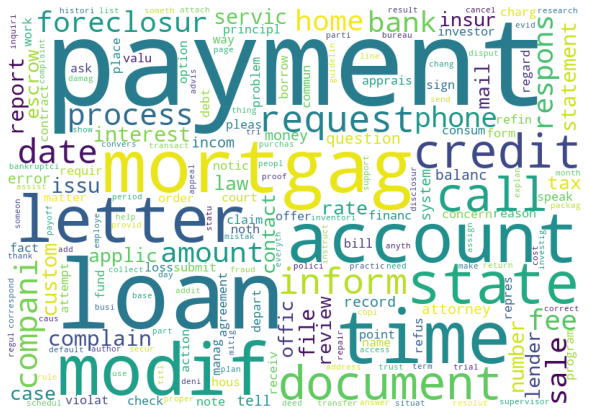

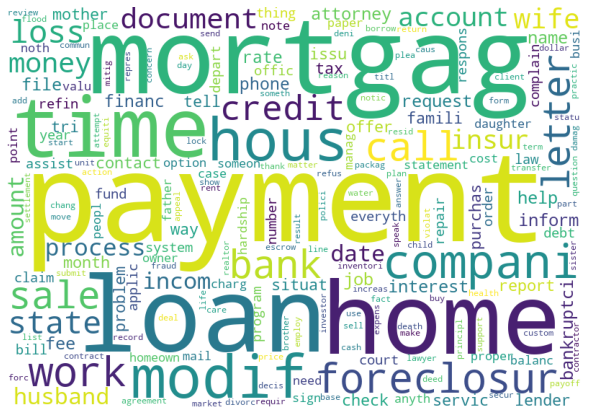

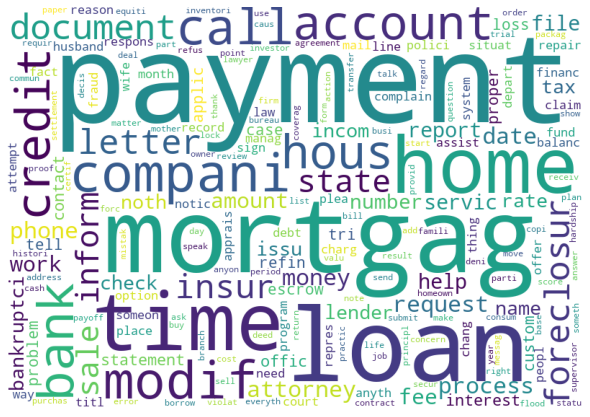

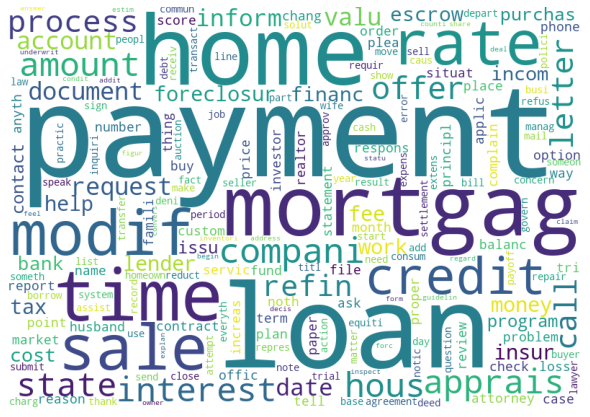

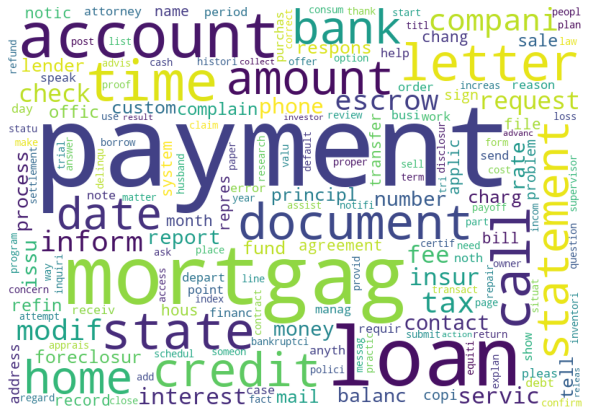

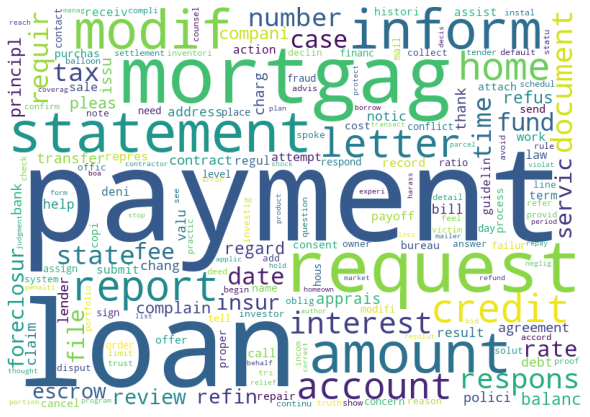

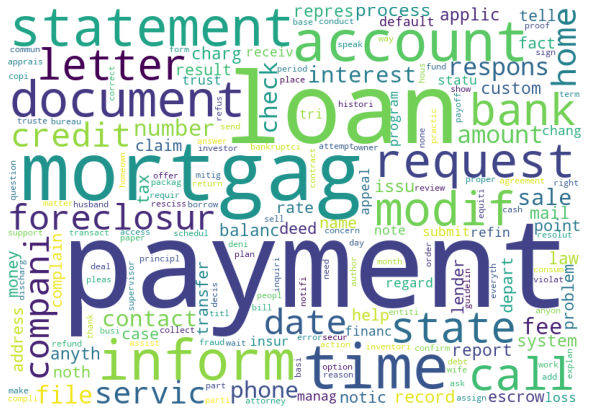

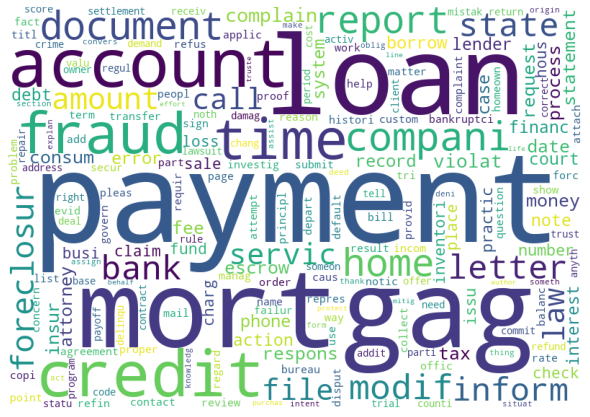

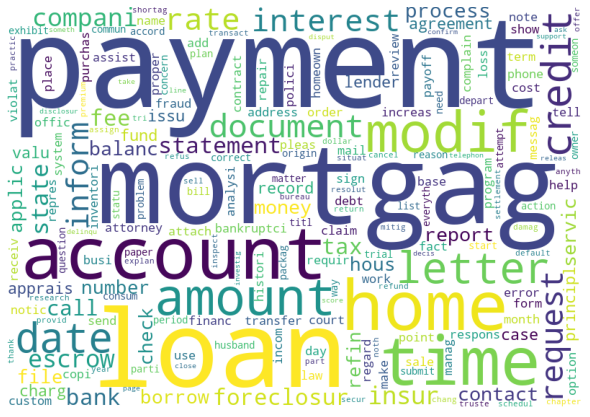

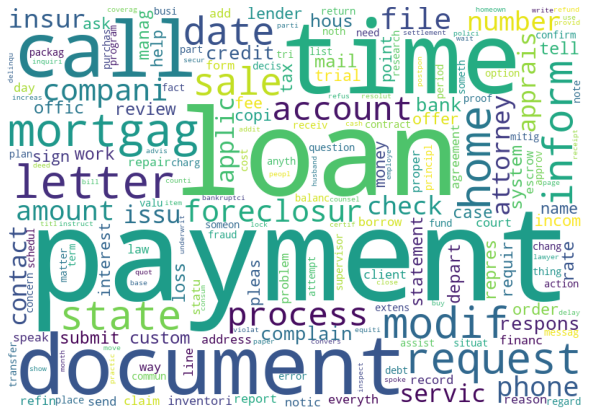

In [15]:
main()

In [16]:
method = "TFIDF"
#method = "LDA"
#method = "BERT"    
#method = "LDA_BERT"
samp_size = 10000
ntopic = 11
tm = Topic_Model(k = ntopic, method = method)
# Fit the topic model by chosen method
tm.fit(sentences, token_lists)

print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
print('Silhouette Score:', get_silhouette(tm))
# visualize and save img
visualize(tm)
for i in range(tm.k):
    get_wordcloud(tm, token_lists, i)

NameError: ignored

### TODO:

* Implement models.ldamulticore – parallelized Latent Dirichlet Allocation using all CPU cores to parallelize and speed up model training.
* Switch from BERT/RoBERTa to SciBERT, BART, and or other models. 